In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from numpy.random import seed
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [4]:
seed(123)

Wczytanie danych, usunięcie brakujących wartości, nadanie etykiet

In [5]:
train_set = pd.read_csv('adult/adult.data', sep=", ", header=None, engine='python')
test_set = pd.read_csv('adult/adult.test', sep=", ", skiprows=1, header=None, engine='python')

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation',
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
              'wage_class']

train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Szybki preprocessing

In [6]:
dataset = pd.concat([train, test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0, '<=50K': 0, '>50K.': 1, '>50K': 1})

dataset.drop(["fnlwgt"], axis=1, inplace=True)
dataset.drop(["education"], axis=1, inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()
d = dict(pd.cut(x[x.index != " United-States"], 5, labels=range(5)))
dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset, drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class", axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class", axis=1)
y_test = test.wage_class

/tmp/ipykernel_577120/4187203541.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0, '<=50K': 0, '>50K.': 1, '>50K': 1})
/tmp/ipykernel_577120/4187203541.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['native_country'] = dataset['native_country'].replace(d)


Stadaryzacja

In [7]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(f"X_train shape:\t{X_train.shape}")
print(f"X_test shape:\t{X_test.shape}")

X_train shape:	(30162, 41)
X_test shape:	(15060, 41)


# Porównaj wyniki działań różnych optymalizacji
Porównaj wyniki działań różnych optymalizacji
```python
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False)
```
```python
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
```
```python
RMSprop = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
```
```python
Adagrad = keras.optimizers.Adagrad(learning_rate=0.01)
```
```python
Adadelta = keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)
```
```python
Adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
```
```python
Adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
```

https://keras.io/optimizers/

In [10]:
optimizers = [
    tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=False),
    tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True),
    tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9),
    tf.keras.optimizers.Adagrad(learning_rate=0.01),
    tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95),
    tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False),
    tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
]

optimizers_names = [
    "SGD",
    "SGD nesterov",
    "RMSprop",
    "Adagrad",
    "Adadelta",
    "Adam",
    "Adam 0.0001"
]

/home/krystianjachna/Desktop/AI/.venv/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
2024-06-07 04:26:44.602685: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [11]:
models_history = []

for i, optimizer in enumerate(optimizers):
    model = Sequential()
    model.add(Dense(100, activation='sigmoid', input_shape=(X_train.shape[1],)))
    model.add(Dense(50, activation='sigmoid'))
    model.add(Dense(10, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=30, verbose=0)
    models_history.append((history, model))
    print(f"finished {optimizers_names[i]}")

/home/krystianjachna/Desktop/AI/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


finished SGD
finished SGD nesterov
finished RMSprop
finished Adagrad
finished Adadelta
finished Adam
finished Adam 0.0001


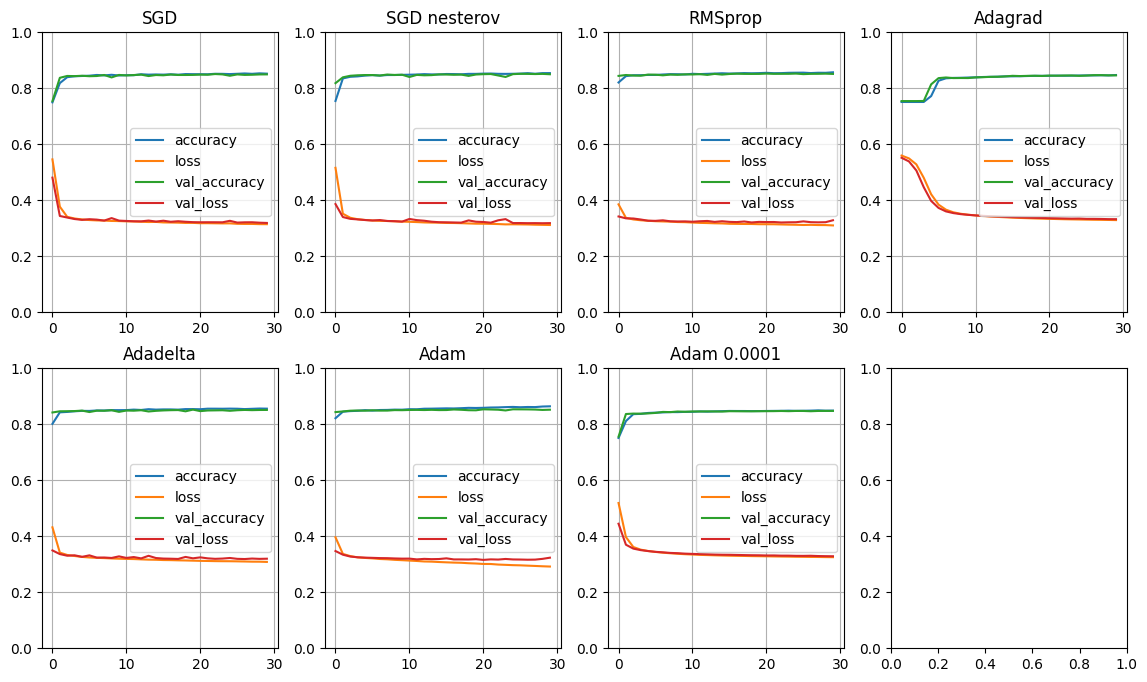

In [18]:
_, axs = plt.subplots(2, 4, figsize=(14, 8))

axs = axs.flatten()

for i, (history, model) in enumerate(models_history):
    pd.DataFrame(history.history).plot(ax=axs[i])
    axs[i].set_title(optimizers_names[i])
    axs[i].set_ylim(0, 1)
    axs[i].grid(True)
    axs[i].legend()

In [20]:
df = pd.DataFrame(columns=["optimizer", "accuracy"])

for i, (history, model) in enumerate(models_history):
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    df.loc[i] = [optimizers_names[i], accuracy]

df

471/471 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
471/471 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step
471/471 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step
471/471 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step
471/471 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step
471/471 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step
471/471 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step


,optimizer,accuracy
0,SGD,0.849602
1,SGD nesterov,0.850066
2,RMSprop,0.851262
3,Adagrad,0.846149
4,Adadelta,0.851195
5,Adam,0.852058
6,Adam 0.0001,0.847742


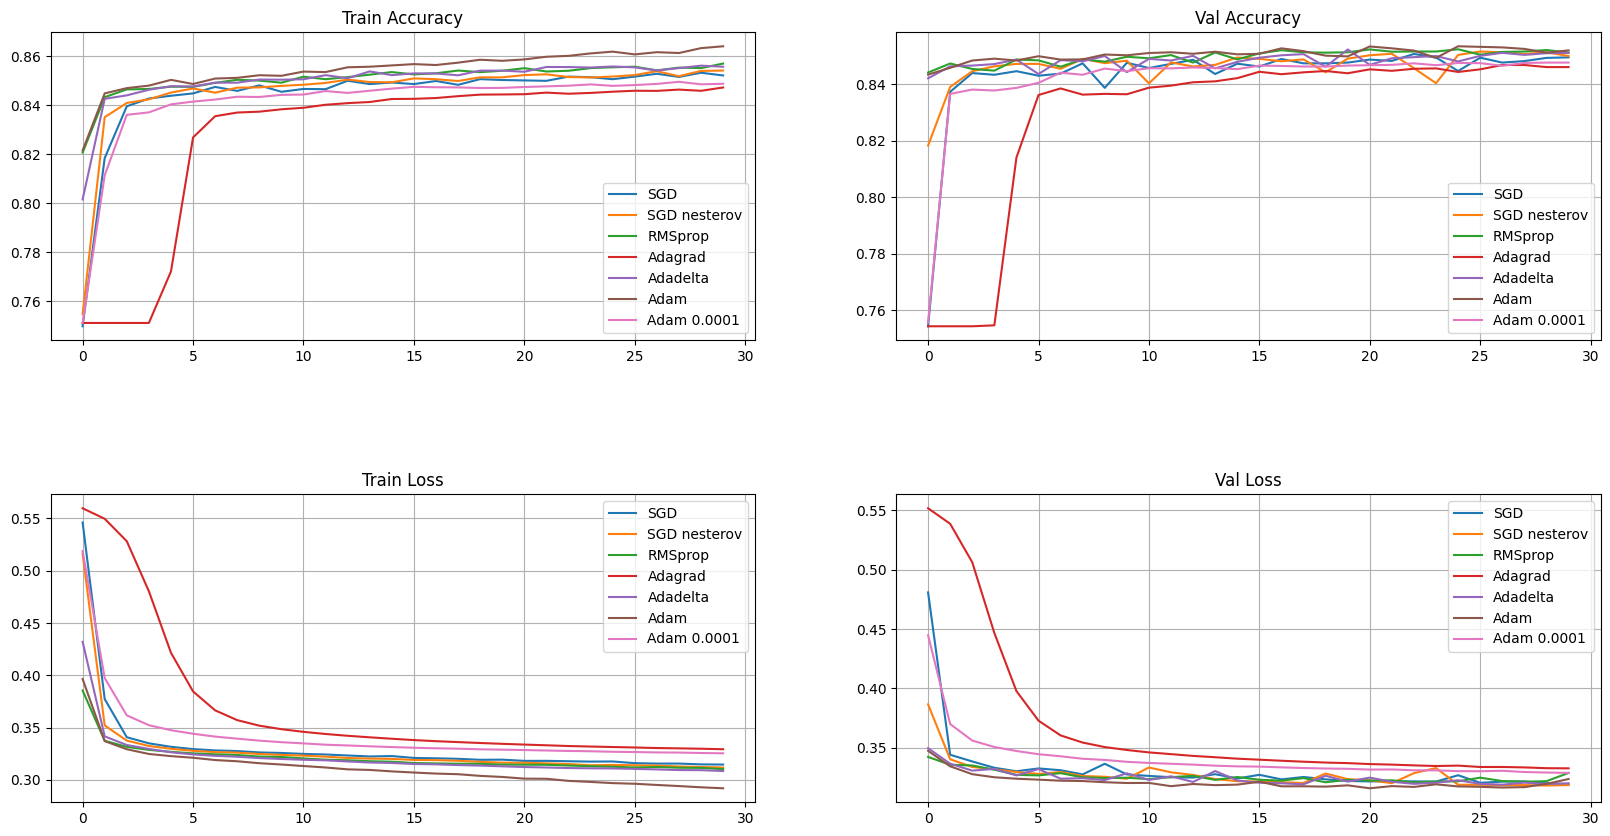

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

for i, (history, _) in enumerate(models_history):
    axs[0][0].plot(history.history['accuracy'], label=f'{optimizers_names[i]}')
    axs[0][1].plot(history.history['val_accuracy'], label=f'{optimizers_names[i]}')
    axs[1][0].plot(history.history['loss'], label=f'{optimizers_names[i]}')
    axs[1][1].plot(history.history['val_loss'], label=f'{optimizers_names[i]}')

axs[0][0].set_title('Train Accuracy')
axs[0][1].set_title('Val Accuracy')
axs[1][0].set_title('Train Loss')
axs[1][1].set_title('Val Loss')

for ax in axs.flatten():
    ax.legend()
    ax.grid(True)

plt.subplots_adjust(hspace=0.5)
plt.show()